In [ ]:
import kagglehub
path = kagglehub.dataset_download('dmitryyemelyanov/chinese-traffic-signs')

100%|██████████| 185M/185M [00:02<00:00, 64.7MB/s]


Extracting files...


In [ ]:
path='/root/.cache/kagglehub/datasets/dmitryyemelyanov/chinese-traffic-signs/versions/2'

In [146]:
# small_shape=(224, 224)
small_shape=(48, 48)

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense ,Flatten ,Conv2D ,MaxPooling2D ,Dropout ,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint
from keras.applications.mobilenet_v2 import MobileNetV2
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

In [147]:
data_dir = path+'/images/'
df = pd.read_csv(path+"/annotations.csv")

In [174]:
file_paths = df[np.array(['file_name', 'x1', 'y1', 'x2', 'y2'])].values
images = []
for file_path, x1, y1, x2, y2 in file_paths:
    image_path = os.path.join(data_dir, file_path)
    image = Image.open(image_path)
    si = np.array(image)[x1:x2, y1:y2]
    images.append(Image.fromarray(si).resize(small_shape))

# file_paths = df['file_name'].values
# images = []
# for file_path in file_paths:
#     image_path = os.path.join(data_dir, file_path)
#     image = Image.open(image_path).resize(small_shape)
#     images.append(np.array(image))

labels = df['category'].values

images = np.array(images)
labels = np.array(labels)

In [170]:
df.columns

Index(['file_name', 'width', 'height', 'x1', 'y1', 'x2', 'y2', 'category'], dtype='object')

array([[[130, 113,  98],
        [130, 113,  98],
        [129, 112,  97],
        ...,
        [107,  93,  83],
        [106,  93,  82],
        [105,  91,  79]],

       [[130, 113,  98],
        [130, 113,  98],
        [128, 113,  97],
        ...,
        [107,  93,  83],
        [106,  92,  82],
        [105,  91,  80]],

       [[130, 112,  98],
        [129, 113,  98],
        [129, 113,  98],
        ...,
        [108,  93,  83],
        [106,  92,  82],
        [105,  92,  81]],

       ...,

       [[115,  96,  84],
        [114, 101,  86],
        [115, 103,  89],
        ...,
        [ 96,  86,  77],
        [ 95,  86,  78],
        [ 95,  86,  77]],

       [[116,  94,  82],
        [115, 100,  86],
        [115, 102,  88],
        ...,
        [ 96,  86,  77],
        [ 95,  86,  77],
        [ 94,  86,  76]],

       [[116,  92,  82],
        [114, 100,  86],
        [115, 102,  89],
        ...,
        [ 97,  86,  77],
        [ 96,  86,  78],
        [ 94,  86,  75]]], dtype=uint8)
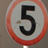

In [175]:
images[0]

оставим только заданные типы знаков

In [176]:
remain=[3,4,5,7,11,16,17,26,30,35,43,55]
a=[index for index,value in enumerate(labels) if value in remain]
inds=np.array(a, dtype=int)

images = images[inds]
labels = labels[inds]

In [177]:
index_dict = {value: index for index, value in enumerate(remain)}
labels=[index_dict[v] for v in labels]

num_classes = len(remain)
labels = to_categorical(labels, num_classes=num_classes)
# labels = tf.one_hot(labels.astype(np.int32), depth=num_classes)

In [178]:
images = images / 255

In [ ]:
labels[-10:-1]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [179]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [242]:
data_augmentation = tf.keras.Sequential([
  layers.RandomTranslation(0.05, 0.05),
  # layers.RandomZoom((-0.3, -0.1)),
  layers.RandomRotation(0.1),
  layers.RandomContrast(0.1),
  # layers.RandomBrightness(0.1)
])

RandomZoom нужен если не обрезать знаки по коордианатам. увеличение RandomBrightness приводит к кратному уменьшению val_acc

In [252]:
model = tf.keras.models.Sequential([
    data_augmentation,
    tf.keras.layers.Conv2D(32, (3,3), strides=(1,1),
                                      padding='same',
                                      activation='relu',
                                      input_shape=(small_shape[0], small_shape[1], 3)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, (3,3), strides=(1,1),
                                      padding='same',
                                      activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, (3,3), strides=(1,1),
                                  padding='same',
                                  activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

4-7к примерно. добавление dence ухудшает

In [253]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
# model.summary()

In [254]:
training_history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=20
)

Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 107s 222ms/step - acc: 0.2224 - loss: 2.1614 - val_acc: 0.4779 - val_loss: 1.2992
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 19s 206ms/step - acc: 0.4660 - loss: 1.3424 - val_acc: 0.5498 - val_loss: 1.0747
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 25s 278ms/step - acc: 0.5734 - loss: 1.0318 - val_acc: 0.6494 - val_loss: 0.7910
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 17s 230ms/step - acc: 0.6511 - loss: 0.8371 - val_acc: 0.7657 - val_loss: 0.5569
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 15s 224ms/step - acc: 0.7568 - loss: 0.6046 - val_acc: 0.8561 - val_loss: 0.4190
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 219ms/step - acc: 0.8350 - loss: 0.4381 - val_acc: 0.8690 - val_loss: 0.3500
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 209ms/step - acc: 0.8561 - loss: 0.3984 - val_acc: 0.9354 - val_loss: 0.2407
Epoch 8/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 24s 260ms/step - acc: 0.8850 - loss: 0.3107 - val_acc: 0.9391 - val_loss: 0.2160
Epoch 9/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 19s 235ms